# Sentiment Analysis with Deep Learning using BERT

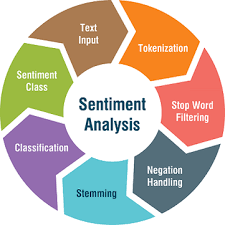

Bidirectional Representation for Transformers, or BERT, is a concept that was put up by Google AI language researchers in 2018. Although its primary goal was to enhance the comprehension of the meaning of Google Search queries, BERT has since emerged as one of the most significant and complete architectures for a variety of natural language tasks, producing cutting-edge results on tasks like classifying sentence pairs and question-answer sets, among others. One of BERT's key characteristics is its flexibility, which enables it to execute many NLP jobs with cutting-edge accuracy (similar to the transfer learning used in Computer vision).

In this notebook, we will be using the Pytorch BERT model of deep learning to perform Multi-class sentiment classification of tweets.

The dataset being used is available on https://www.kaggle.com/datasets/ashkhagan/smile-twitter-emotion-dataset.

## Exploratory Data Analysis and Preprocessing

In [1]:
import torch
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('Corona_NLP_train.csv', encoding='latin-1')

In [3]:
df.head(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive


In [4]:
df.dropna(inplace=True)

In [5]:
df['category']=df['Sentiment']

In [6]:
df.category.value_counts()

Positive              9110
Negative              7763
Neutral               6172
Extremely Positive    5273
Extremely Negative    4249
Name: category, dtype: int64

In [7]:
possible_labels = df.category.unique()

In [8]:
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [9]:
df['label'] = df.category.replace(label_dict)

In [10]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,category,label
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,Neutral,0
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,Positive,1
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,Positive,1
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive,Positive,1
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive,Positive,1


## Training/Validation Split

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_val, y_train, y_val = train_test_split(df.OriginalTweet.values, df.label.values, test_size = 0.15, random_state=17, stratify = df.label.values)

In [13]:
df['data_type'] = ['not_set']*df.shape[0]

In [14]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,category,label,data_type
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,Neutral,0,not_set
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,Positive,1,not_set
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,Positive,1,not_set
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive,Positive,1,not_set
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive,Positive,1,not_set


In [15]:
df.groupby(['category', 'label', 'data_type']).count()

,,,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
category,label,data_type,,,,,,
Extremely Negative,4,not_set,4249,4249,4249,4249,4249,4249
Extremely Positive,3,not_set,5273,5273,5273,5273,5273,5273
Negative,2,not_set,7763,7763,7763,7763,7763,7763
Neutral,0,not_set,6172,6172,6172,6172,6172,6172
Positive,1,not_set,9110,9110,9110,9110,9110,9110


##  Loading Tokenizer and Encoding our Data

In [16]:
pip install transformers

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [17]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [19]:
X_train

array(['If I were @GovAbbott I\'d contact @everly_well to get bulk prices on #Covid_19 test kits and work faster to figure out the real picture here in Texas.  #texas has the nation\'s largest "rainy day fund." It\'s pouring outside in case you hadn\'t noticed! ??????',
       "Are you heading out to the grocery store for some items? Don't forget to clean your car during this #CoronavirusPandemic . Cash Cars Buyer offers the following tips: https://t.co/jEZ0yol7TB #WashYourHands #Covid_19 https://t.co/aPnUxVltwy",
       'What have you said today that youÂ\x92d never have said a month ago? \r\r\n\r\r\nMe: The queue to get into the supermarket only took me half an hour.\r\r\n\r\r\n#ThursdayThoughts #COVID19Pandemic \r\r\n#StayHomeSaveLives \r\r\n#lockdownuk',
       ...,
       "So I'm putting flavoured sparkling water in my gin, due to no tonic water of any description at the supermarket. Thanks a lot panic buyers.\r\r\n\r\r\n#Covid_19 #panicbuying #FirstWorldProblems",
       'Just po

In [20]:
encoded_data_train = tokenizer.batch_encode_plus(X_train,add_special_tokens=True,return_attention_mask=True,pad_to_max_length=True,max_length=256,return_tensors='pt')

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.


In [21]:
encoded_data_val= tokenizer.batch_encode_plus(X_val,add_special_tokens=True,return_attention_mask=True,pad_to_max_length=True,max_length=256,return_tensors='pt')

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.


In [22]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(y_train)

In [23]:
input_ids_val = encoded_data_val['input_ids']
attention_masks_val= encoded_data_val['attention_mask']
labels_val = torch.tensor(y_val)

In [24]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [25]:
len(dataset_train)

27681

In [26]:
len(dataset_val)

4886

##  Setting up BERT Pretrained Model

In [27]:
from transformers import BertForSequenceClassification

In [28]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = len(label_dict), output_attentions=False,output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

##  Creating Data Loaders

In [29]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [30]:
batch_size = 32 #32

dataloader_train = DataLoader(dataset_train,sampler=RandomSampler(dataset_train),batch_size=batch_size)

In [31]:

dataloader_val = DataLoader(dataset_val,sampler=RandomSampler(dataset_val),batch_size=32)

##  Setting Up Optimizer and Scheduler

In [32]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [33]:
optimizer = AdamW(model.parameters(),lr=1e-5, #2e-5 > 5e-5 
                 eps=1e-8)

In [34]:
epochs=16

scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps=len(dataloader_train)*epochs)

##  Defining our Performance Metrics

In [35]:
import numpy as np

In [36]:
from sklearn.metrics import f1_score

In [37]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [38]:
def accuracy_per_class(preds, labels):
    labels_dict_inverse = {v: k for k,v in label_dict.items()}
    
    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {labels_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

## Creating our Training Loop

In [39]:
import random

seed_val = 8
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [41]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals


In [42]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    
    progress_bar =  tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch),leave=False,disable=False)
    
    for batch in progress_bar:
        
        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {
            'input_ids' : batch[0],
            'attention_mask' : batch[1],
            'labels' : batch[2]
            
        }
        
        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss' : '{:.3f}'.format(loss.item()/len(batch))})
        
    #torch.save(model.state_dict(), f'Models/BERT_ft_epoch{epoch}.model')
    
    tqdm.write('\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write('Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/866 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: {loss_train_avg}
Validation loss: 0.72190303934945
F1 Score (weighted): 0.7251466637223963


Epoch 2:   0%|          | 0/866 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: {loss_train_avg}
Validation loss: 0.572690809084699
F1 Score (weighted): 0.7880788618773847


Epoch 3:   0%|          | 0/866 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: {loss_train_avg}
Validation loss: 0.5376800248046326
F1 Score (weighted): 0.8058742924659348


Epoch 4:   0%|          | 0/866 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: {loss_train_avg}
Validation loss: 0.46737883819474113
F1 Score (weighted): 0.8410290152908529


Epoch 5:   0%|          | 0/866 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: {loss_train_avg}
Validation loss: 0.4825159191987873
F1 Score (weighted): 0.8460849031276099


Epoch 6:   0%|          | 0/866 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: {loss_train_avg}
Validation loss: 0.5273619552258573
F1 Score (weighted): 0.8461118256921029


Epoch 7:   0%|          | 0/866 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: {loss_train_avg}
Validation loss: 0.5602961171637563
F1 Score (weighted): 0.8424624026425624


Epoch 8:   0%|          | 0/866 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: {loss_train_avg}
Validation loss: 0.6761378675845324
F1 Score (weighted): 0.8341248556127537


Epoch 9:   0%|          | 0/866 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: {loss_train_avg}
Validation loss: 0.6682793072430916
F1 Score (weighted): 0.8410901090454167


Epoch 10:   0%|          | 0/866 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: {loss_train_avg}
Validation loss: 0.6959155514544132
F1 Score (weighted): 0.8432948622586209


Epoch 11:   0%|          | 0/866 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: {loss_train_avg}
Validation loss: 0.7160127562975961
F1 Score (weighted): 0.8455358861074075


Epoch 12:   0%|          | 0/866 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: {loss_train_avg}
Validation loss: 0.735393245217506
F1 Score (weighted): 0.8472324292764735


Epoch 13:   0%|          | 0/866 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: {loss_train_avg}
Validation loss: 0.7229742973166353
F1 Score (weighted): 0.8509019558983776


Epoch 14:   0%|          | 0/866 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: {loss_train_avg}
Validation loss: 0.7642602067398139
F1 Score (weighted): 0.8474916468233625


Epoch 15:   0%|          | 0/866 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: {loss_train_avg}
Validation loss: 0.7818451492858478
F1 Score (weighted): 0.8463090132865652


Epoch 16:   0%|          | 0/866 [00:00<?, ?it/s]


Epoch {epoch}
Training loss: {loss_train_avg}
Validation loss: 0.7990934519352866
F1 Score (weighted): 0.8464725224927667


##  Loading and Evaluating our Model

In [43]:
_, predictions, true_vals = evaluate(dataloader_val)

In [44]:
accuracy_per_class(predictions, true_vals )

Class: Neutral
Accuracy: 821/926

Class: Positive
Accuracy: 1103/1367

Class: Negative
Accuracy: 927/1165

Class: Extremely Positive
Accuracy: 718/791

Class: Extremely Negative
Accuracy: 570/637

